#### Convolutional Neural Network-Based Asthma Detection from Audio Signals using MFCC Features

In [59]:
# Import Required Libraries
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from cryptography.utils import CryptographyDeprecationWarning
warnings.filterwarnings("ignore", category=CryptographyDeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [61]:
# Dataset Path
data_path = r"C:\Users\KIIT\Desktop\MINI PRO 2\MINI PRO 2\Asthma Detection Dataset Version 2"

In [63]:
# Visualize Spectrogram & MFCC
def visualize_audio(file_path):
    audio, sr = librosa.load(file_path, sr=22050)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    librosa.display.specshow(spectrogram, sr=sr, x_axis="time", y_axis="log")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")

    plt.subplot(1, 2, 2)
    librosa.display.specshow(mfcc, sr=sr, x_axis="time")
    plt.colorbar()
    plt.title("MFCC")
    plt.show()

In [65]:
# Augment Audio
def augment_audio(audio, sr):
    noise = np.random.randn(len(audio)) * 0.005
    audio_noisy = audio + noise
    audio_stretched = librosa.effects.time_stretch(audio, rate=1.1)
    audio_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    return [audio, audio_noisy, audio_stretched, audio_shifted]

In [67]:
# Extract MFCC
def extract_features(file_path, max_pad_len=100):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [69]:
# Load Audio Data
def load_audio_data(data_path):
    audio_data, labels = [], []
    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                try:
                    audio, sr = librosa.load(file_path, sr=22050)
                    for augmented_audio in augment_audio(audio, sr):
                        mfcc = librosa.feature.mfcc(y=augmented_audio, sr=sr, n_mfcc=40)
                        if mfcc.shape[1] < 100:
                            mfcc = np.pad(mfcc, ((0, 0), (0, 100 - mfcc.shape[1])), mode="constant")
                        else:
                            mfcc = mfcc[:, :100]
                        audio_data.append(mfcc)
                        labels.append(label)
                except Exception as e:
                    print(f"Failed to process {file_path}: {e}")
    return np.array(audio_data), np.array(labels)

In [71]:
# Load dataset
audio_data, labels = load_audio_data(data_path)

In [72]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

In [73]:
# Train-test split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    audio_data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

In [74]:
# Reshape for CNN
X_train = X_train.reshape(-1, 40, 100, 1)
X_test = X_test.reshape(-1, 40, 100, 1)

In [75]:
# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [76]:
# Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [77]:
# Build CNN Model
model = Sequential([
    Input(shape=(40, 100, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [78]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [79]:
# Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

In [80]:
# Train the Model
history = model.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stop],
    verbose=2
)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.28070, saving model to best_model.keras
122/122 - 23s - 189ms/step - accuracy: 0.2212 - loss: 3.2978 - val_accuracy: 0.2807 - val_loss: 1.5908
Epoch 2/30

Epoch 2: val_accuracy improved from 0.28070 to 0.32611, saving model to best_model.keras
122/122 - 43s - 354ms/step - accuracy: 0.2735 - loss: 1.5707 - val_accuracy: 0.3261 - val_loss: 1.5174
Epoch 3/30

Epoch 3: val_accuracy improved from 0.32611 to 0.47059, saving model to best_model.keras
122/122 - 14s - 115ms/step - accuracy: 0.3646 - loss: 1.4783 - val_accuracy: 0.4706 - val_loss: 1.3169
Epoch 4/30

Epoch 4: val_accuracy improved from 0.47059 to 0.51806, saving model to best_model.keras
122/122 - 15s - 119ms/step - accuracy: 0.4165 - loss: 1.4165 - val_accuracy: 0.5181 - val_loss: 1.2700
Epoch 5/30

Epoch 5: val_accuracy improved from 0.51806 to 0.52528, saving model to best_model.keras
122/122 - 14s - 119ms/step - accuracy: 0.4403 - loss: 1.3687 - val_accuracy: 0.5253 - 

In [81]:
# Load Best Model
model = load_model("best_model.keras")

In [82]:
# Evaluate Model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step 


In [302]:
# Train Prediction
train_loss, train_accuracy = model.evaluate(X_train, y_train_cat, verbose=0)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

Train Accuracy: 92.18%


In [201]:
# ROC Curve 
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [202]:
# Binarize the true and predicted labels for multi-class ROC
y_test_bin = label_binarize(y_true_classes, classes=[i for i in range(num_classes)])
y_pred_bin = y_pred
fpr = dict()
tpr = dict()
roc_auc = dict()

In [206]:
# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

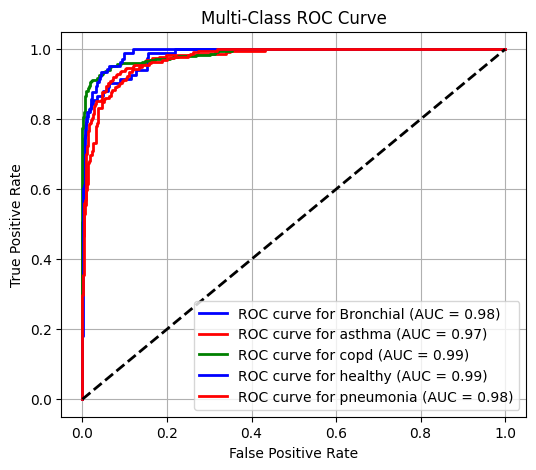

In [208]:
# Plot all ROC curves
plt.figure(figsize=(6, 5))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [210]:
# Classification Report
print("\n Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_, zero_division=1))


 Classification Report:
              precision    recall  f1-score   support

   Bronchial       0.86      0.81      0.83        83
      asthma       0.78      0.92      0.84       231
        copd       0.98      0.87      0.92       321
     healthy       0.73      0.92      0.81       106
   pneumonia       0.91      0.80      0.85       228

    accuracy                           0.86       969
   macro avg       0.85      0.86      0.85       969
weighted avg       0.88      0.86      0.87       969



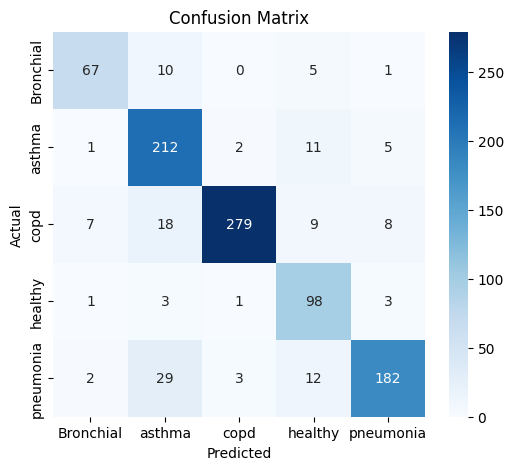

In [212]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

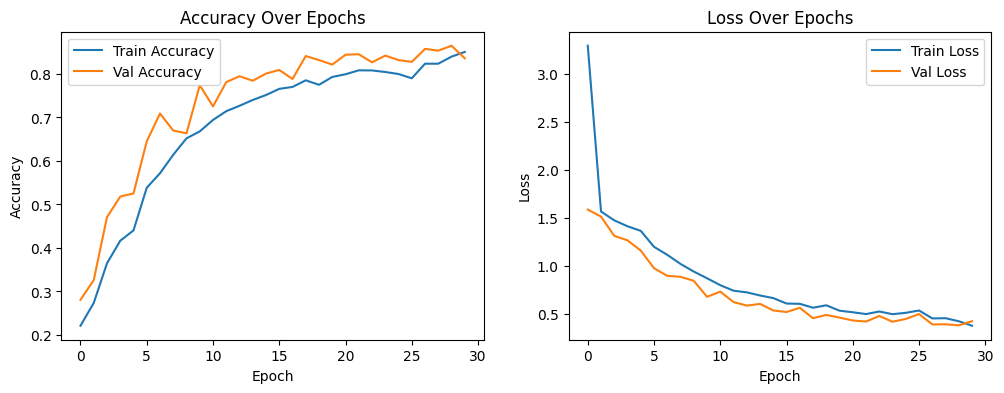

In [230]:
# Accuracy & Loss Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

In [276]:
# Real-time Prediction
def predict_audio(file_path):
    mfcc = extract_features(file_path)
    if mfcc is None:
        return "Invalid audio file!"
    mfcc = mfcc.reshape(1, 40, 100, 1)
    pred = model.predict(mfcc)
    return label_encoder.inverse_transform([np.argmax(pred)])

In [278]:
# Test Prediction
print("Predicted class:", predict_audio("path_to_new_audio_1.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted class: ['asthma']


In [280]:
# Test Prediction
print("Predicted class:", predict_audio("path_to_new_audio_2.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted class: ['Bronchial']


In [282]:
# Test Prediction
print("Predicted class:", predict_audio("path_to_new_audio_3.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted class: ['copd']


In [284]:
# Test Prediction
print("Predicted class:", predict_audio("path_to_new_audio_4.wav"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted class: ['pneumonia']


In [300]:
# Evaluate on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 86.48%
